<img src="Figures/top_ML.png" alt="Drawing" style="width: 1000px;"/>

# Sesión 5. Ejemplo de aprendizaje supervisado: regresión.

## *Predicción de generación fotovoltaica para autoconsumo*

**Objetivo:** predecir la generación fotovoltaica para el día siguiente de un hogar, con el objetivo de gestionar de manera inteligente sus consumos. Se utilizarán datos históricos de la variable target que queremos predecir (datos históricos de generación fotovoltaica) y de otros atributos (features) que pueden ayudar a predecir modelo, como por ejemplo la irradiancia o temperatura.


### Antes de empezar:

* En el archivo **S5_ejemploPV1.csv** se encuentra el conjunto de datos de entrada de este ejemplo (atributos + etiqueta). 

## **1. Importar librerías y datos**

In [50]:
# Importamos las librerías
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Cargamos el conjunto de datos de entrada
dataset = pd.read_csv('Data/S5_ejemploPV1.csv', delimiter=';')

## **2. Comprender los datos**

Es necesario visualizar y comprender los datos con los que vamos a trabajar, así como conocer sus características. 

1. ¿Cuántos datos hay? ¿Cuántos atributos hay en los datos?  
2. ¿Qué significan?
3. ¿Falta algún dato?
4. ¿Están balanceadas las etiquetas? 
4. Resumen estadístico del conjunto de datos de entrada.

**1. ¿Cuántos datos hay?**   **¿Cuántos atributos hay en los datos?**

In [2]:
# Filasxcolumnas de los datos
dataset.shape

(25058, 8)

In [3]:
# Observa las primeras 5 filas de datos
dataset.head()

,localhour,pressure,temperature,humidity,windspeed,rain,radiation,pvgen
0,19/02/2015 12:00,1024.4,17,56,4,0.0,672,6.646
1,19/02/2015 13:00,1022.8,18,47,4,0.0,865,7.364
2,19/02/2015 14:00,1021.4,19,47,4,0.0,781,7.418
3,19/02/2015 15:00,1019.9,20,41,4,0.0,664,6.616
4,19/02/2015 16:00,1018.6,21,42,4,0.0,505,4.795


In [4]:
# Formato de los datos
dataset.dtypes

localhour       object
pressure       float64
temperature      int64
humidity         int64
windspeed        int64
rain           float64
radiation        int64
pvgen          float64
dtype: object

In [5]:
# Convert localhour in datetime
dataset['localhour'] = pd.to_datetime(dataset['localhour'])

**3. ¿Falta algún dato?** Se comprueba si falta algún dato, y de ser así, se realiza el recuento de celdas vacías en cada atributo. En este caso, no faltan  datos.

In [6]:
# Comprobar si falta algún dato y en qué atributo
dataset.isna().sum()

localhour      0
pressure       0
temperature    0
humidity       0
windspeed      0
rain           0
radiation      0
pvgen          0
dtype: int64

## **3. Visualizar los datos**

Una manera visual de entender los datos de entrada. 

1. Boxplots
2. Matriz de correlación

### 3.1 Boxplots

El boxplot (diagrama de caja) nos permite identificar los valores atípicos y comparar distribuciones. Además, se conoce como se distribuyen el 50% de los valores (dentro de la caja).

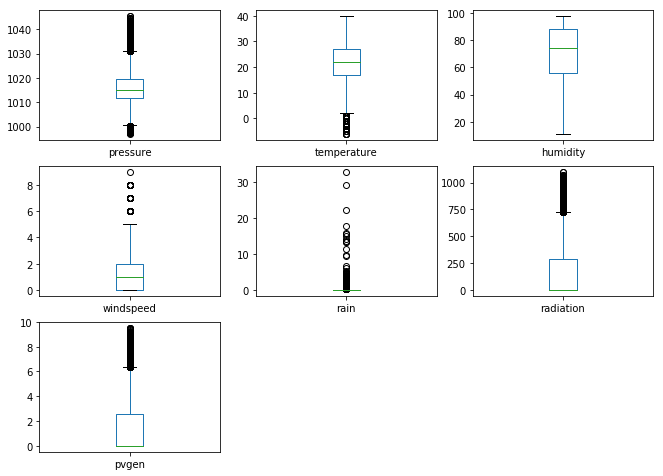

In [7]:
atributos_boxplot = dataset.plot(kind='box', subplots=True, layout=(4, 3), figsize=(11, 11), sharex=False,
                                 sharey=False, fontsize=10)

### **4. Matriz de correlación** 

Tabla de doble entrada de los atributos

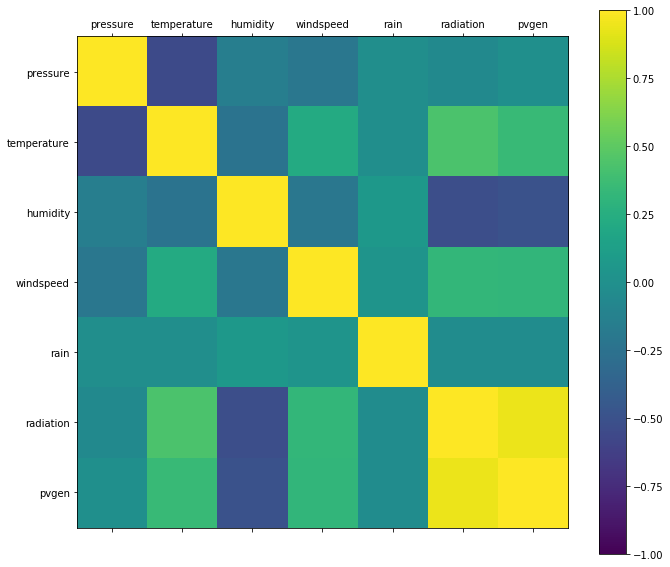

In [8]:
# Cálculo de coeficientes de correlación
corr_matrix = dataset.corr(method='pearson') 

# Matriz de correlación
fig = plt.figure(figsize=(11, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr_matrix, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(dataset.columns)-1, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr_matrix.columns)
ax.set_yticklabels(corr_matrix.columns)
plt.show()


## *4. Preparar los datos*

1. Limpieza de datos (data cleaning)
2. Transformación

**1. Limpieza de datos (data cleaning)**

No exisiten Nan en los datos de entrada y no se eliminarán los outliers en este ejemplo. Esto se tratará en la práctica. 


**2. Transformación**. 

Añado columnas de ``hora`` y ``mes`` a través de la columna datetime. 
Se escalan los datos

In [9]:
# Añado columnas de mes y hora
dataset['mes'] = pd.DatetimeIndex(dataset['localhour']).month
dataset['hora'] = pd.DatetimeIndex(dataset['localhour']).hour
dataset.drop(['localhour'], axis=1, inplace=True)
dataset

,pressure,temperature,humidity,windspeed,rain,radiation,pvgen,mes,hora
0,1024.4,17,56,4,0.0,672,6.646,2,12
1,1022.8,18,47,4,0.0,865,7.364,2,13
2,1021.4,19,47,4,0.0,781,7.418,2,14
3,1019.9,20,41,4,0.0,664,6.616,2,15
4,1018.6,21,42,4,0.0,505,4.795,2,16
...,...,...,...,...,...,...,...,...,...
25053,1012.9,29,63,2,0.0,196,0.250,2,19
25054,1012.8,27,70,0,0.0,7,-0.008,2,20
25055,1013.3,26,71,0,0.0,0,-0.009,2,21
25056,1013.9,26,78,0,0.0,0,-0.008,2,22


Divido los datos en **atributos**: X (features) y **etiquetas**: y (target)

In [10]:
# Atributos X (features); etiquetas y (target)
X = dataset.drop(['pvgen'], axis=1) 
y = dataset['pvgen']

Se escalan los datos utilizando el método de *MinMaxScaler()*, que escala y traduce cada atributo individualmente de tal manera que está dentro del rango [0,1]. Esto es necesario hacerlo cuando las escalas de los atributos son diferentes (eg. radiación [0, 650], velocidad del viento [2, 15])

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Escalo los atributos/features
scaler = MinMaxScaler()
X_df = X.copy()
X_scaled = pd.DataFrame(scaler.fit_transform(X_df))
X_scaled.columns = X_df.columns
X_scaled.head()

,pressure,temperature,humidity,windspeed,rain,radiation,mes,hora
0,0.564948,0.500000,0.517241,0.444444,0.0,0.610354,0.090909,0.521739
1,0.531959,0.521739,0.413793,0.444444,0.0,0.785649,0.090909,0.565217
2,0.503093,0.543478,0.413793,0.444444,0.0,0.709355,0.090909,0.608696
3,0.472165,0.565217,0.344828,0.444444,0.0,0.603088,0.090909,0.652174
4,0.445361,0.586957,0.356322,0.444444,0.0,0.458674,0.090909,0.695652


In [12]:
from sklearn.preprocessing import MinMaxScaler

# Escalo los atributos/features
scaler = MinMaxScaler()

# Escalo el target/label
y_df = y.copy()
y_df = pd.DataFrame(y_df)
y_scaled = scaler.fit_transform(y_df)
# y_scaled.columns = y_df.columns
y_scaled = np.ravel(y_scaled)
y_scaled

array([6.97299560e-01, 7.72451329e-01, 7.78103412e-01, ...,
       7.32677413e-04, 8.37345614e-04, 8.37345614e-04])

## *5. Dividir los datos*

Se dividen los datos en datos de entreno ``X_train``, ``y_train``, datos de validación ``X_val``, ``y_val`` y datos de test ``X_test``, ``y_test``


In [13]:
from sklearn.model_selection import train_test_split

test_size = 0.2  # porcentaje de los datos de entrada que utilizaré para validar el modelo

# Divido los datos en datos de entreno, validación y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=test_size,
                                                    shuffle=False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size,
                                                    shuffle=False)

## *6. Construcción y evaluación de modelos*

* La métrica de evaluacion seleccionada es **R2 y RMSE**. 


In [14]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

num_folds = 5
error_metrics = {'neg_root_mean_squared_error', 'r2'}
models = {('MLP', MLPRegressor()),('RFR', RandomForestRegressor()),
          ('GradBR', GradientBoostingRegressor()), ('AdaB', AdaBoostRegressor())}


results = [] # guarda los resultados de las métricas de evaluación
names = []  # Nombre de cada algoritmo
msg = []  # imprime el resumen del método de cross-validation


Se entrenan cada uno de los modelos, se guarda su resultado y se comparan gráficamente.

Métrica de evaluación:  r2
Modelo  AdaB
Modelo  RFR
Modelo  GradBR
Modelo  MLP
[('AdaB', 0.8352095644608255, 0.037858677554015605), ('RFR', 0.9081371162134257, 0.018813664139971247), ('GradBR', 0.9055785610326759, 0.015406525709712527), ('MLP', 0.8940165072309958, 0.0234674329045701)]


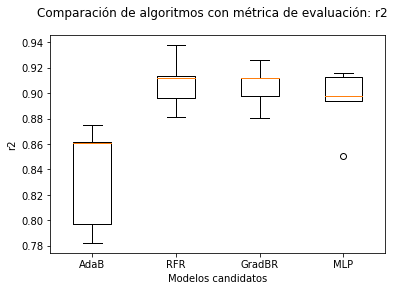

Métrica de evaluación:  neg_root_mean_squared_error
Modelo  AdaB
Modelo  RFR
Modelo  GradBR
Modelo  MLP
[('AdaB', 0.8352095644608255, 0.037858677554015605), ('RFR', 0.9081371162134257, 0.018813664139971247), ('GradBR', 0.9055785610326759, 0.015406525709712527), ('MLP', 0.8940165072309958, 0.0234674329045701), ('AdaB', -0.11175929582747701, 0.015180344340139804), ('RFR', -0.07145529034278676, 0.01315977546661818), ('GradBR', -0.07264374451543158, 0.01243326426174328), ('MLP', -0.07730957592360597, 0.01084110950923107)]


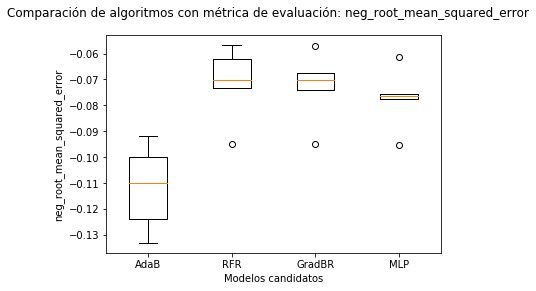

In [15]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

# Entreno con validación cruzada
for scoring in error_metrics:
    print('Métrica de evaluación: ', scoring)
    for name, model in models:
        print('Modelo ', name)
        cross_validation = KFold(n_splits=num_folds, shuffle=False)
        cv_results = cross_val_score(model, X_train, y_train, cv=cross_validation, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        resume = (name, cv_results.mean(), cv_results.std())
        msg.append(resume)
    print(msg)

    # Comparar resultados entre algoritmos
    fig = plt.figure()
    fig.suptitle('Comparación de algoritmos con métrica de evaluación: %s' %scoring)
    ax = fig.add_subplot(111)
    ax.set_xlabel('Modelos candidatos')
    ax.set_ylabel('%s' %scoring)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

    results = []


## *7. Ajustar hiperparámetros*

Pasos para realizar el hiperajuste de los parámetros:
* Especificar el modelo a ajustar*
* Especificar una métrica para optimizar: *balanced_accuracy*
* Definir los rangos de los parámetros de búsqueda: *params*
* Asignar un método de validación: *KFold*
* Entrenar con los datos de validación: *X_val*

In [16]:

modelo = RandomForestRegressor()
scoring='r2'
params = {
    # Number of trees in random forest
    'n_estimators': [100, 500, 800, 1000],  # default=100
     # Maximum number of levels in tree
    'max_depth': [2, None],  #deafult = None
     # Method of selecting samples for training each tree
}


# Búsqueda de la mejor combinación de hiperparámetros
cross_validation = KFold(n_splits=5, shuffle=False)
my_cv = cross_validation.split(X_val)
gsearch = GridSearchCV(estimator=modelo, param_grid=params, scoring=scoring, cv=my_cv)
gsearch.fit(X_val, y_val)

# Imprimo el mejor resultado
print("Mejor resultado: %f utilizando los siguientes hiperparámetros %s" % (gsearch.best_score_, gsearch.best_params_))
means = gsearch.cv_results_['mean_test_score']
stds = gsearch.cv_results_['std_test_score']
params = gsearch.cv_results_['params']

Mejor resultado: 0.936015 utilizando los siguientes hiperparámetros {'max_depth': None, 'n_estimators': 100}


## *8. Evaluación final del modelo*


Métricas de evaluación:
  * RMSE
  * R2

    
Finalmente, entreno al modelo con los hiperparámetros óptimos encontrados en el apartado anterior y realizo las predicciones. 

In [17]:

modelo_final = RandomForestRegressor(n_estimators=100)
modelo_final.fit(X_train,y_train)  # Se entrena al modelo 
y_predict = modelo_final.predict(X_test)  # Se calculan las predicciones


In [21]:
y_predict

array([0.08385315, 0.19029569, 0.30498768, ..., 0.00075356, 0.00075356,
       0.00075356])

In [87]:
import math 
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# scaler = MinMaxScaler()
# Invertir el escalado y plotear los resultados
y_test_unsc = np.reshape(y_test, (len(y_test), 1))
y_test_inv = scaler.inverse_transform(y_test_unsc)

y_predict_uns = np.reshape(y_predict, (len(y_predict), 1))
y_predict_inv = scaler.inverse_transform(y_predict_uns)

In [88]:
# Errores  

math.sqrt(mean_squared_error(y_test_inv, y_predict_inv))

0.6687947576575698

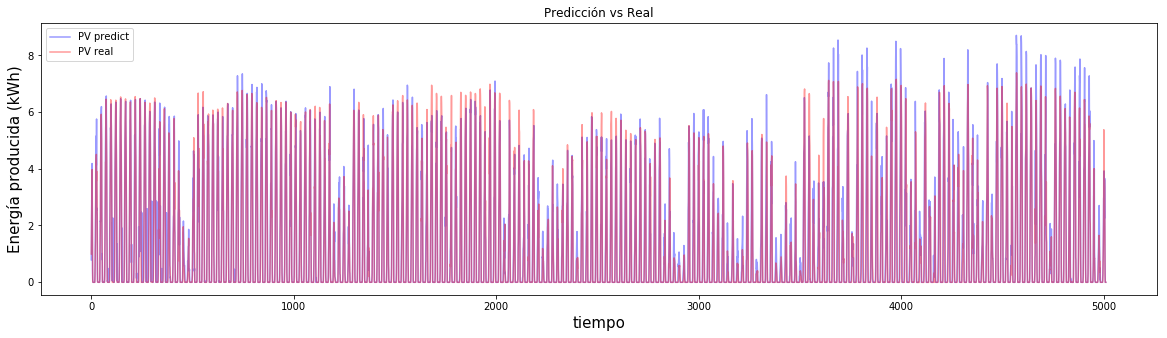

In [89]:
# Plot y_predict vs y_test

x = range(len(y_predict_inv))
plt.figure(figsize=(20,5))
plt.xlabel('tiempo', size=15)
plt.ylabel('Energía producida (kWh)', size=15)
plt.plot(x, y_predict_inv, alpha=0.4, color='blue', label='PV predict')
plt.plot(x, y_test_inv, alpha=0.4, color='red',  label='PV real')
plt.title('Predicción vs Real')
plt.legend()
plt.show()

## Necesitamos hacer Zoom in!!


In [102]:
import plotly.graph_objects as go  # Importamos la librería de plotly

init = list(range(len(y_predict_inv)))
y_predict_plot = pd.DataFrame(data=y_predict_inv, index=init, columns=['predict'])
y_test_plot = pd.DataFrame(data=y_test_inv, index=init, columns=['test'])


# Creamos la figura
fig = go.Figure()
fig.add_trace(go.Scatter(x=init, y=y_predict_plot['predict'][init],
                    mode='lines',
                    name='PV predicción'))
fig.add_trace(go.Scatter(x=init, y=y_test_plot['test'][init],
                     mode='lines', name='PV real'))


# Editamos la figura
fig.update_layout(autosize=False,
                  width=1000,
                    height=500,
                    title='Predicción vs Real',
                   xaxis_title='Periodos',
                   yaxis_title='Energía (kWh)')


fig.show()

### Features más importantes 

¿Cuales son las features que tienen más peso es este ejemplo? 

Feature ranking:
1. feature 5 (0.907483)radiation
2. feature 7 (0.046920)hora
3. feature 2 (0.015009)humidity
4. feature 1 (0.011181)temperature
5. feature 0 (0.008662)pressure
6. feature 6 (0.006785)mes
7. feature 3 (0.003749)windspeed
8. feature 4 (0.000211)rain


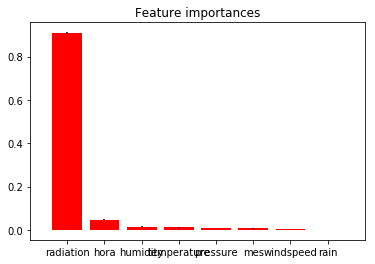

In [51]:

# Imprimimos el feature ranking
importances = gsearch.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in gsearch.best_estimator_.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
feat = X.columns
feat_or=[]
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]])+feat[indices[f]])
    feat_or.append(feat[indices[f]])

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feat_or)
plt.xlim([-1, X.shape[1]])
plt.show()